In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from glob import glob
from scipy.optimize import fmin
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy import interpolate

In [4]:
basedir = "/Users/laote/sdsu/Research/binary/tess_keplerEBs"
basedir2 = "/Users/laote/sdsu/Research/binary/tess_alldata/Curves"
curvedir = "/Users/laote/sdsu/Research/binary/tess_alldata/Curves"

lc_list = glob("%s/*.txt" %basedir2)
lc_list = sorted(lc_list, key=lambda name: int(name[57:-14]))

bbb = "/home/zlin/research"
bbbcurve = bbb + "/Curves2"
bbbb = bbb + lc_list[0][53:]
bbbbcurve = bbbcurve + lc_list[0][53:]


bbbb[23:-14]
bbbbcurve[31:-14]

'001026032'

In [174]:
def line_func(x, a, b):
    return a*x + b

def fit_med(datadir):
    data = np.genfromtxt(datadir,names="time,flux,et,ef")
    med = np.median(data['flux']) 
    std = np.std(data['flux'])
    c = (data['flux'] > (med-std)) & (data['flux'] < (med+std))
    para, epara = curve_fit(line_func, data['time'][c], data['flux'][c])
    slope = para[0]; inter = para[1]
    return slope, inter

In [175]:
def fit_peak(datadir, display=False):
    data = np.genfromtxt(datadir,names="time,flux,et,ef")
    slope, inter = fit_med(datadir)
    
    time_diff = data['time'][1:] - data['time'][:-1]
    error_point = np.argmax(time_diff)
    
    time = np.append(data['time'][20:error_point-40],data['time'][error_point+40:-20])
    flux = np.append(data['flux'][20:error_point-40],data['flux'][error_point+40:-20])
    
    norm_flux = flux - line_func(time,slope,inter)
    med = np.median(norm_flux) 
    std = np.std(norm_flux)
    peaks = find_peaks(-norm_flux, height=-(med-1*std))

    peaks_pos = peaks[0]
    height = -peaks[1]['peak_heights']
    
    if len(height) >= 1:
        sort_height = sorted(height)
        if sort_height[0] <= med-4.5*std:
            result = 'win'
        elif sort_height[0] >= med-2.5*std:
            result = 'lose'
        else:
            result = 'i dont know'
    else:
        result = 'lose'

#     fittime = []
#     for i in range(len(time[peaks_pos])):
#         fitx = [];fity = [];
#         for j in range(-2,3,1):
#             fitx.append(time[peaks_pos+j][i])
#             fity.append(norm_flux[peaks_pos+j][i])
#         z = np.polyfit(fitx,fity,2)
#         func = np.poly1d(z)
#         minimum = -z[1]/(2*z[0])
#         fittime.append(minimum)

    if display == True:

        L = len(norm_flux)
        yf = np.abs(np.fft.fft(norm_flux))[range(int(L/2))]
        xf = (time[2]-time[1])*np.arange(L)[range(int(L/2))]
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
        plt.plot(data['time'],data['flux'],'c.')
        plt.plot([time[0],time[-1]],\
                 [(np.median(flux)),(np.median(flux))],'r-')
        plt.subplot(1,3,2)
        plt.plot(time,norm_flux,'c-')
#         plt.plot(fittime,height,'rx')
        plt.plot(time[peaks_pos],height,'rx')
        plt.plot([time[0],time[-1]],[(med),(med)],'r-')
        plt.plot([time[0],time[-1]],[(med-4.5*std),(med-4.5*std)],'r-')

        plt.subplot(1,3,3)
        plt.plot(xf,yf,'c-')
        plt.show()

#     return fittime, height, result
    return result


In [176]:
def find_max_slope(datadir,loop=400):
    a = 0
    for i in range(loop):
        slope, inter = fit_med(datadir[i])
        if np.abs(slope) > a:
            a = np.abs(slope)
            w = i
    print(a,w)

/Users/laote/sdsu/Research/binary/tess_alldata/Curves/kid002580872_SEC014_LC.txt


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide


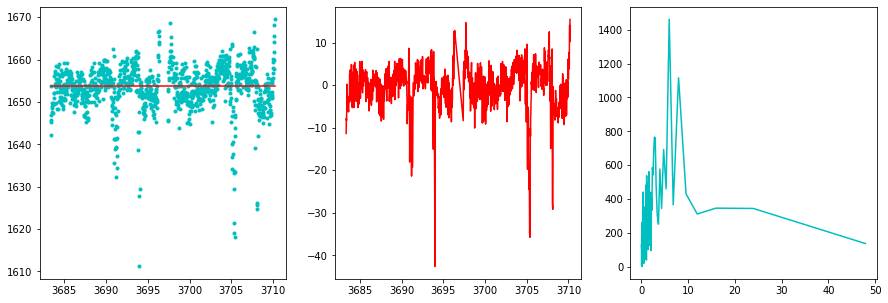

In [177]:
test_curve = lc_list[90]
print(lc_list[70])

# FFT
test = np.genfromtxt(test_curve,names="time,flux,et,ef")
slope, inter = fit_med(test_curve)
norm_flux = test['flux']-line_func(test['time'],slope,inter)

L = len(norm_flux)
yf = np.abs(np.fft.fft(norm_flux))[range(int(L/2))]
xf = (test['time'][2]-test['time'][1])*np.arange(L)[range(int(L/2))]

result = fit_peak(test_curve,display=False)


plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(test['time'],test['flux'],'c.')
plt.plot([test['time'][0],test['time'][-1]],\
         [(np.median(test['flux'])),(np.median(test['flux']))],'r-')
plt.subplot(1,3,2)
plt.plot(test['time'],norm_flux,'r-')
plt.subplot(1,3,3)
plt.plot(1/xf,yf,'c-')
plt.show()

In [178]:
new_list = []
for j in range(len(lc_list)):
    first_sort = np.genfromtxt(lc_list[j],names="time,flux,et,ef")
    time_diff = first_sort['time'][1:] - first_sort['time'][:-1]

    if (np.max(time_diff) < 2) & (np.sum(time_diff > 0.7) <2):
        new_list.append(lc_list[j])
np.save("new_list.npy",new_list)

In [179]:
# new_list = np.load("new_list.npy")
# len(new_list)

In [180]:
# win_list = []
# lose_list = []
# counts = 0
# for i in range(len(new_list)):
#     result = fit_peak(new_list[i])
#     if result == 'win':
#         counts += 1
#         choise = 0
#         win_list.append(new_list[i])
#     if result == 'lose':
#         choise = 1
#         lose_list.append(new_list[i])
#     else:
#         None

# print(len(win_list))
# print(len(lose_list))

# np.save("win_list.npy",win_list)
# np.save("lose_list.npy",lose_list)

In [181]:
# fit_peak(win_list[1806],display=True)

In [182]:
win_list = np.load("win_list.npy")
lose_list = np.load("lose_list.npy")

In [183]:
def save_img(datadir,choise=0):
    data = np.genfromtxt(datadir,names="time,flux,et,ef")
    
    time_diff = data['time'][1:] - data['time'][:-1]
    error_point = np.argmax(time_diff)
    
    time = np.append(data['time'][20:error_point-30],data['time'][error_point+30:-20])
    flux = np.append(data['flux'][20:error_point-30],data['flux'][error_point+30:-20])
    
    
    norm_flux = (flux - np.median(flux))/(np.max(flux) - np.min(flux))
    norm_flux = np.minimum(norm_flux, np.std(norm_flux))
    
    plt.figure(figsize=(5,5))
    plt.plot(time,norm_flux,'k-')
    plt.axis('off')
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.savefig("/Users/laote/sdsu/Research/binary/tess_image/%s_%s.jpg" %(datadir[54:-7],choise))
#     plt.savefig("/Users/laote/sdsu/Research/binary/tess_image/unknown/%s.jpg" %(datadir[54:-7]))
    plt.show()
    

    return None

In [2]:
# for i in range(30):
#     save_img(win_list[i])

In [1]:
# for i in range(len(lose_list)):
#     save_img(lose_list[i],choise=1)

In [26]:
# fit_peak(win_list[1010],display=True)

'/Users/laote/sdsu/Research/binary/tess_alldata/Curves/kid002997455_SEC014_LC.txt'

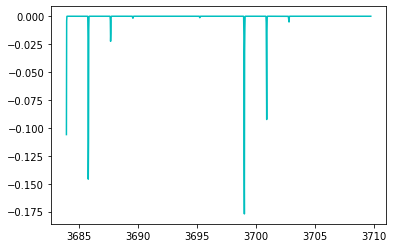

In [171]:
def see_period(datadir):
    data = np.genfromtxt(datadir,names="time,flux,et,ef")

    
    time_diff = data['time'][1:] - data['time'][:-1]
    error_point = np.argmax(time_diff)
    
    time = np.append(data['time'][20:error_point-30],data['time'][error_point+30:-20])
    flux = np.append(data['flux'][20:error_point-30],data['flux'][error_point+30:-20])

    med = np.median(flux) 
    std = np.std(flux)
    
    temp = interpolate.interp1d(time,flux)
    new_x = np.arange(np.min(time), np.max(time), 0.1)
    norm_flux = temp(new_x)
    
    L = len(new_x)
    yf = np.abs(np.fft.fft(norm_flux))[range(int(L/2))]
    xf = (0.1)*np.arange(L)[range(int(L/2))]
    
    plt.plot(time,-np.exp(-50*flux/med)/np.sum(np.exp(-50*flux/med)),'c')

#     plt.plot(1/xf,yf,'c')
# #     plt.yscale('log')
#     plt.xscale('log')
    
#     plt.plot(data['time'],data['flux'])
#     plt.plot(new_x,norm_flux)
    
see_period(win_list[50])
win_list[70]

In [98]:
binary = np.genfromtxt("classification.txt",dtype=str)
binary_lc_dir = []
for i in range(len(binary)):
    binary_lc_dir.append(curvedir + '/' + binary[i][0] + '_LC.txt')